**Problem Introduction:**
<br>
The problem we will tackle is predicting the max temperature for tomorrow in a city using one year of past weather data. I am using Seattle, WA but feel free to find data for your own city using the NOAA Climate Data Online tool.
<br>
We are going to act as if we don’t have access to any weather forecasts (and besides, it’s more fun to make our own predictions rather than rely on others). 
<br>
What we do have access to is one year of historical max temperatures, the temperatures for the previous two days, and an estimate from a friend who is always claiming to know everything about the weather. 
<br>
**Why Supervised ?**<br>
This is a supervised, regression machine learning problem. It’s supervised because we have both the features (data for the city) and the targets (temperature) that we want to predict. During training, we give the random forest both the features and targets and it must learn how to map the data to a prediction. 
<br>
**Why Regression ?**<br>
Moreover, this is a regression task because the target value is continuous (as opposed to discrete classes in classification). That’s pretty much all the background we need, so let’s start!

**Roadmap:**
<br>
Before we jump right into programming, we should lay out a brief guide to keep us on track. The following steps form the basis for any machine learning workflow once we have a problem and model in mind:
<br>
1. State the question and determine required data
2. Acquire the data in an accessible format
3. Identify and correct missing data points/anomalies as required
4. Prepare the data for the machine learning model
5. Establish a baseline model that you aim to exceed
6. Train the model on the training data
7. Make predictions on the test data
8. Compare predictions to the known test set targets and calculate performance metrics
9. If performance is not satisfactory, adjust the model, acquire more data, or try a different modeling technique
10. Interpret model and report results visually and numerically

Step 1 is already checked off! We have our question: “can we predict the max temperature tomorrow for our city?” and we know we have access to historical max temperatures for the past year in Seattle, WA.

In [2]:
# Data acquisition
import pandas as pd

dataset = pd.read_csv('temps.csv')
dataset.head(6)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41
5,2016,1,6,Wed,40,44,46.1,51,43,49,48,40


In [3]:
# Identify anomalies/ missing data
print('The shape is: ', dataset.shape)

# Since, the shape is not 366 considering 366 days in 2016, means there are missing value sin dataset

#stats for each column
dataset.describe()

The shape is:  (348, 12)


,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


#### Following are explanations of the columns:
---------------------------------------------------------------
* year: 2016 for all data points

* month: number for month of the year

* day: number for day of the year

* week: day of the week as a character string

* temp_2: max temperature 2 days prior

* temp_1: max temperature 1 day prior

* average: historical average max temperature

* actual: max temperature measurement

* friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

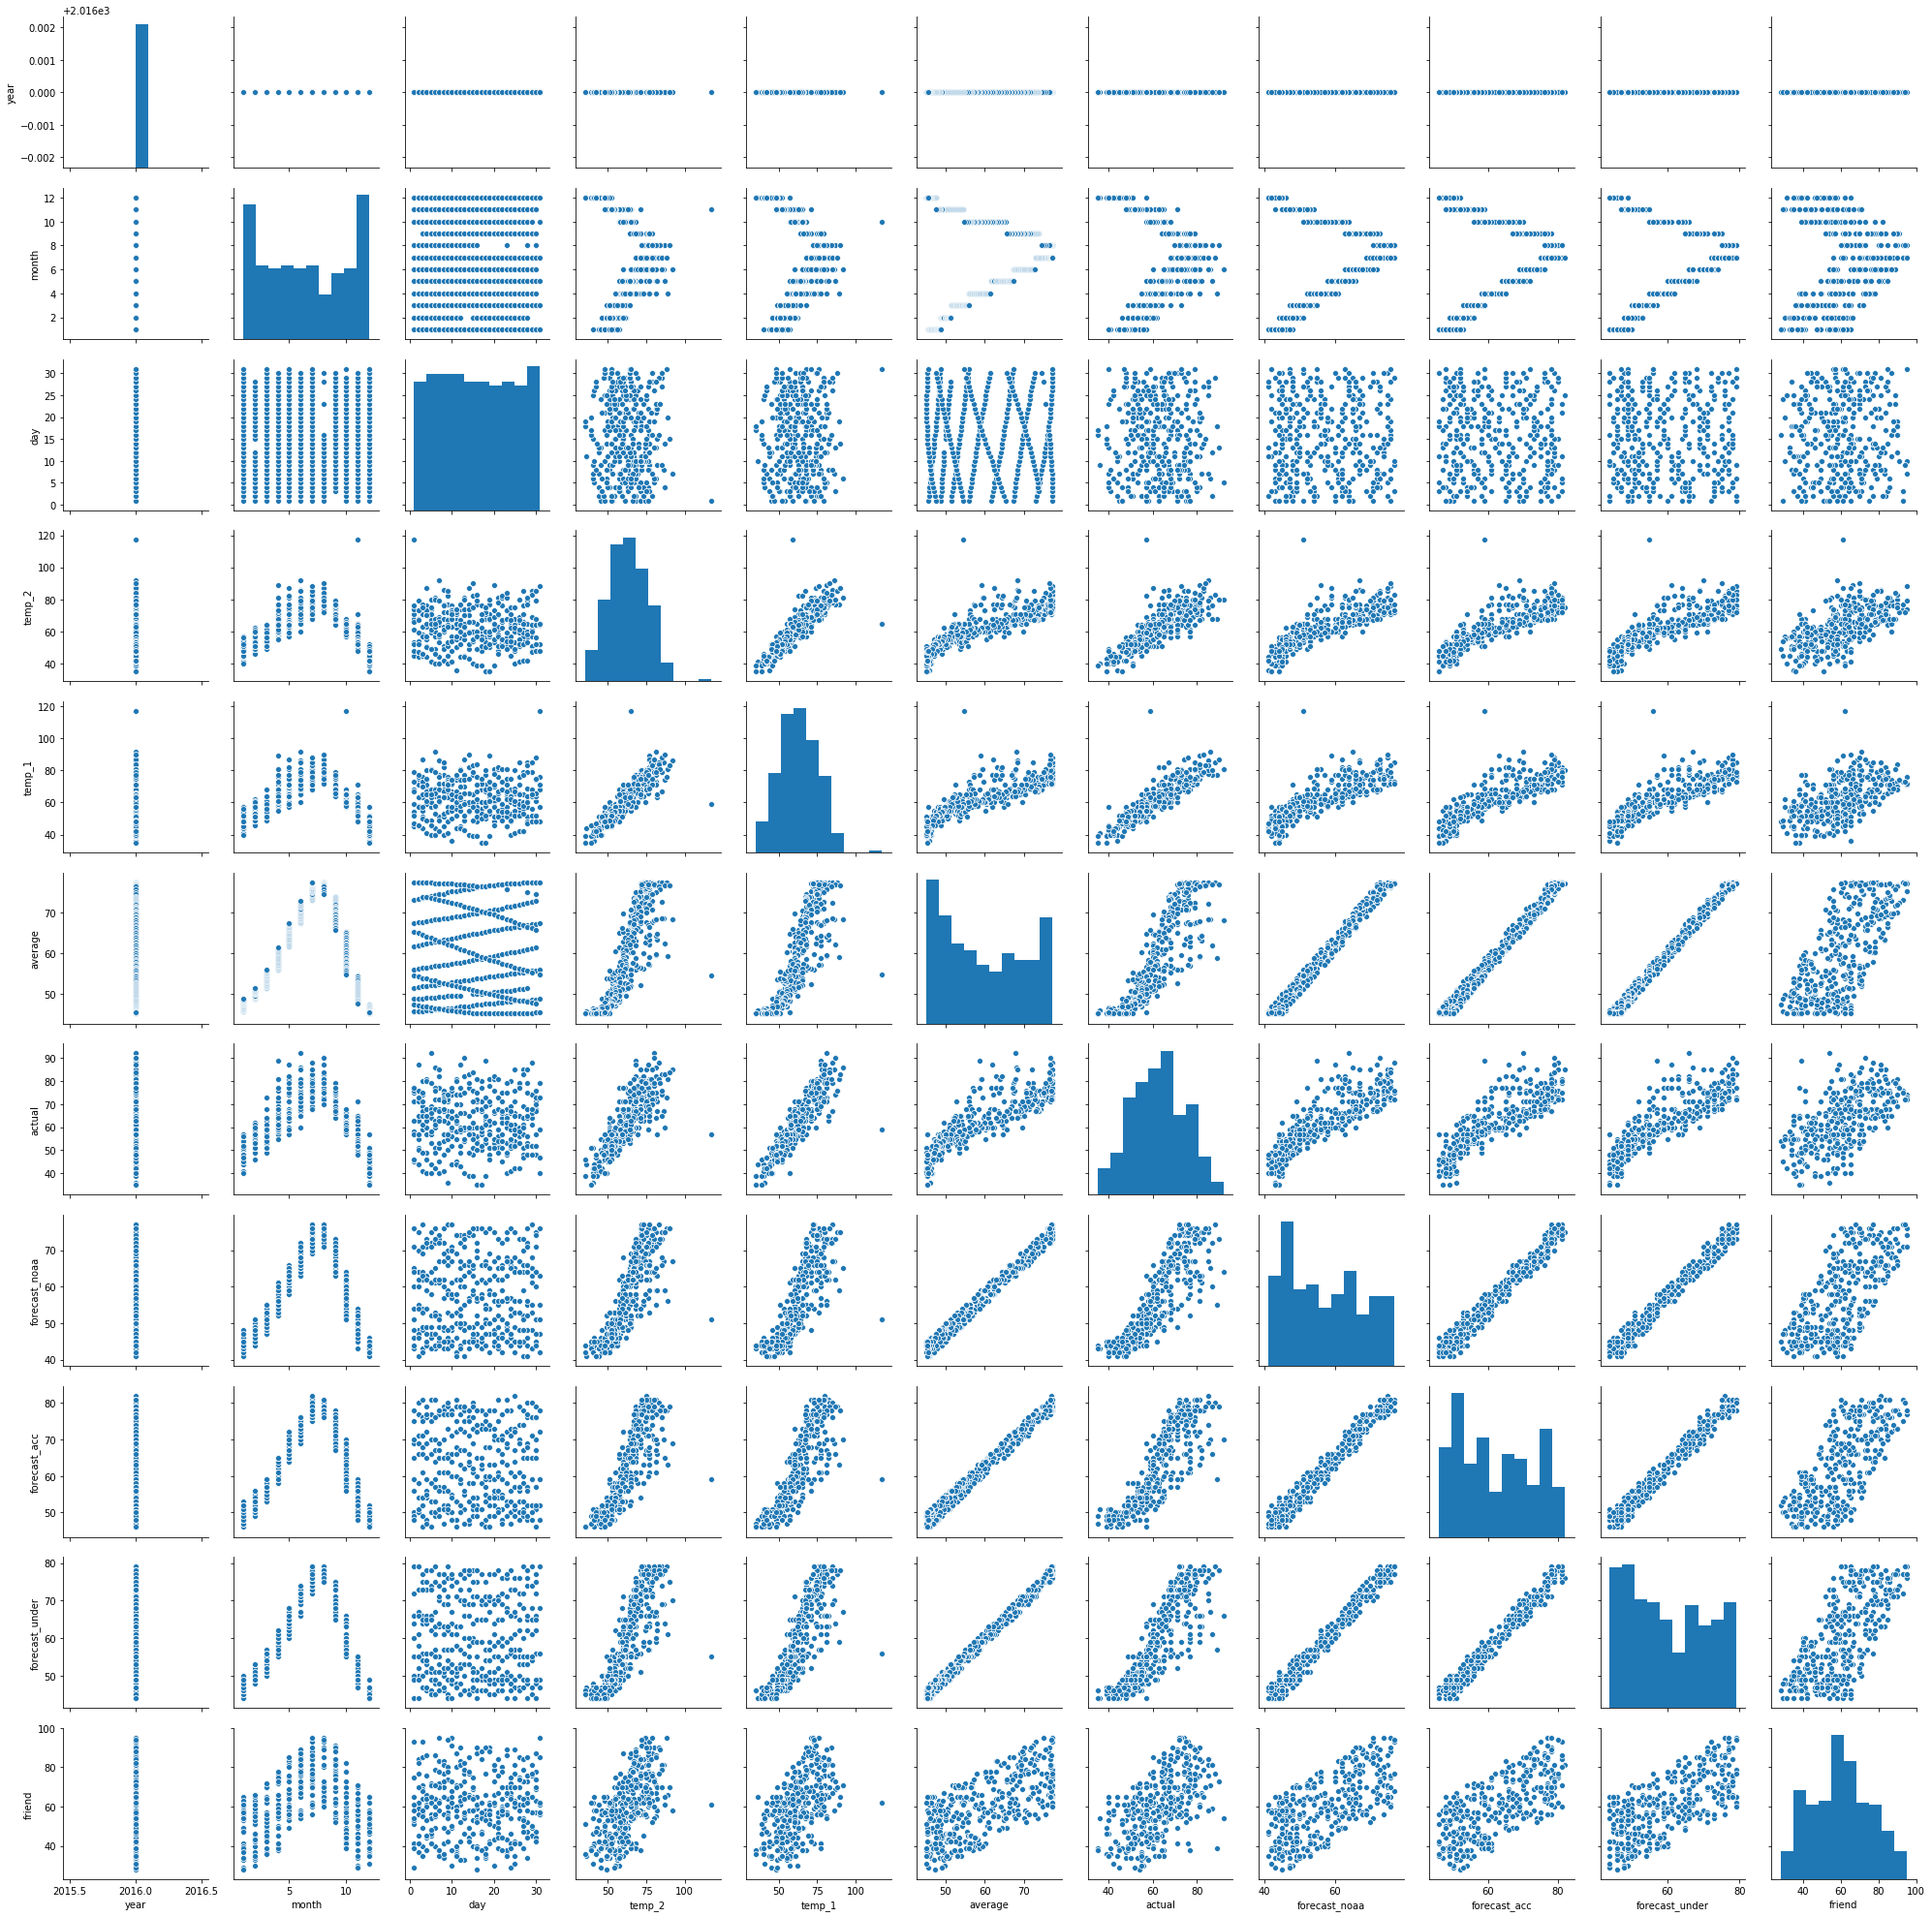

In [6]:
# plotting the data
import seaborn as sns

sns.pairplot(dataset)

### Data Preparation

1. **One hot encoding**<br>
This process takes categorical variables, such as days of the week and converts it to a numerical representation without an arbitrary ordering

In [4]:
dataset = pd.get_dummies(dataset)
dataset.iloc[:,5:].head(5)

print(dataset.shape)

(348, 18)


2. **Features and Targets and Convert Data to Arrays**<br>
Now, we need to separate the data into the features and targets. The target, also known as the label, is the value we want to predict, in this case the actual max temperature and the features are all the columns the model uses to make a prediction.

In [6]:
# Usenumpy to convert to arrays
import numpy as np

#labels ae the values we want to predict
labels = np.array(dataset['actual'])
# remove the labels from the festures axis = 1 meabs columns
dataset = dataset.drop('actual', axis = 1)
#saving dataset names for later use
features_list = list(dataset.columns)
#convert to numpy arrays
dataset = np.array(dataset)

3. **Training and Testing sets**


In [10]:
from sklearn.model_selection import train_test_split

#split the data into the training and testing set
train_features, test_features, train_labels, test_labels = train_test_split(dataset, labels, test_size = 0.25, random_state = 42)

In [11]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 17)
Training Labels Shape: (261,)
Testing Features Shape: (87, 17)
Testing Labels Shape: (87,)


4. **Establish Baseline**

In [14]:
#the baseline predictions are the historical averages
baseline_preds = test_features[: , features_list.index('average')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
#baseline errors, display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baeline error: ', round(np.mean(baseline_errors), 2))

Average baeline error:  5.06


5. **Train Model**

In [21]:
# import the model we're using
from sklearn.ensemble import RandomForestRegressor
# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# train the model on traiing data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

6. **Make Predictions on the Test Set**

In [22]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


Our average estimate is off by 3.83 degrees. That is more than a 1 degree average improvement over the baseline. Although this might not seem significant, it is nearly 25% better than the baseline, which, depending on the field and the problem, could represent millions of dollars to a company.

7. **Determine Performance Metrics**

In [24]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


That looks pretty good! Our model has learned how to predict the maximum temperature for the next day in Seattle with 94% accuracy.

8. **Improve Model if Necessary**

9. **Interpret Model and Report Results**

 9.1 **Visualizing a Single Decision Tree**<br>
 One of the coolest parts of the Random Forest implementation in Skicit-learn is we can actually examine any of the trees in the forest. We will select one tree, and save the whole tree as an image.
 <br>
 The following code takes one tree from the forest and saves it as an image.

In [43]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [45]:
# Limit depth of tree to 3 levels to make it understadable
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = features_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

9.2 **Variable Importances**
<br>
In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. The importances returned in Skicit-learn represent how much including a particular variable improves the prediction. The actual calculation of the importance is beyond the scope of this post, but we can use the numbers to make relative comparisons between variables.

The code here takes advantage of a number of tricks in the Python language, namely list comprehensive, zip, sorting, and argument unpacking

In [30]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
# Sort the feature importances by most important first
features_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: year                 Importance: 0.0
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: temp_1               Importance: 0.66
Variable: average              Importance: 0.15
Variable: forecast_noaa        Importance: 0.05
Variable: forecast_acc         Importance: 0.03
Variable: forecast_under       Importance: 0.02
Variable: friend               Importance: 0.02
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


In future implementations of the model, we can remove those variables that have no importance and the performance will not suffer. Additionally, if we are using a different model, say a support vector machine, we could use the random forest feature importances as a kind of feature selection method. Let’s quickly make a random forest with only the two most important variables, the max temperature 1 day prior and the historical average and see how the performance compares.

In [32]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [features_list.index('temp_1'), features_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.


This tells us that we actually do not need all the data we collected to make accurate predictions! If we were to continue using this model, we could only collect the two variables and achieve nearly the same performance. In a production setting, we would need to weigh the decrease in accuracy versus the extra time required to obtain more information. Knowing how to find the right balance between performance and cost is an essential skill for a machine learning engineer and will ultimately depend on the problem!

Now, I feel confident that my model can predict the maximum temperature tomorrow with 94% accuracy from one year of historical data. <br>
<br>
I have to make some charts! In addition to being enjoyable to look at, charts can help us diagnose our model because they compress a lot of numbers into an image that we can quickly examine.

9.3 **Visualizations**

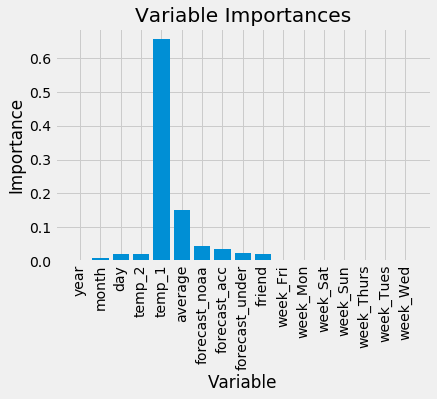

In [35]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, features_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');



Next, we can plot the entire dataset with predictions highlighted. This requires a little data manipulation, but its not too difficult. We can use this plot to determine if there are any outliers in either the data or our predictions.

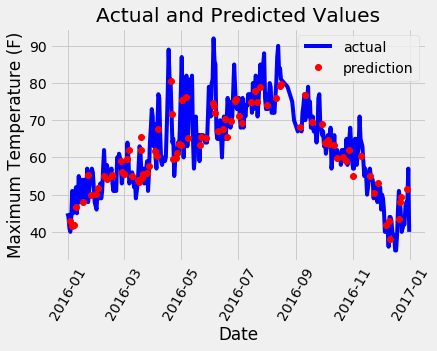

In [37]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = dataset[:, features_list.index('month')]
days = dataset[:, features_list.index('day')]
years = dataset[:, features_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, features_list.index('month')]
days = test_features[:, features_list.index('day')]
years = test_features[:, features_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

A little bit of work for a nice looking graph! It doesn’t look as if we have any noticeable outliers that need to be corrected. <br>
<br>
To further diagnose the model, we can plot residuals (the errors) to see if our model has a tendency to over-predict or under-predict, and we can also see if the residuals are normally distributed. 
<br>
<br>However, I will just make one final chart showing the actual values, the temperature one day previous, the historical average, and our friend’s prediction. This will allow us to see the difference between useful variables and those that aren’t so helpful.

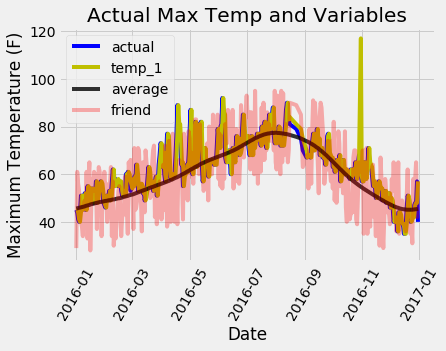

In [39]:
# Make the data accessible for plotting
true_data['temp_1'] = dataset[:, features_list.index('temp_1')]
true_data['average'] = dataset[:, features_list.index('average')]
true_data['friend'] = dataset[:, features_list.index('friend')]
# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)
# Formatting plot
plt.legend(); plt.xticks(rotation = '60');
# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');

It is a little hard to make out all the lines, but we can see why the max temperature one day prior and the historical max temperature are useful for predicting max temperature while our friend is not (don’t give up on the friend yet, but maybe also don’t place so much weight on their estimate!). Graphs such as this are often helpful to make ahead of time so we can choose the variables to include, but they also can be used for diagnosis.